In [1]:
from __future__ import division

import datautils
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
# Read in the data
num_classes = 10 #250
res = 128

tic = time.clock()
X_train, y_train, X_val, y_val, X_test, y_test, labels = datautils.get_data(num_classes=num_classes, res=128)
toc = time.clock()
print ("Read {} images in {:5} seconds".format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0], toc - tic))
print ("X_train: ", X_train.shape)
print ("y_train: ", y_train.shape)
print ("X_val: ", X_val.shape)
print ("y_val: ", y_val.shape)
print ("X_test: ", X_test.shape)
print ("y_test: ", y_test.shape)

Read 800 images in 0.37176600000000004 seconds
X_train:  (640, 128, 128, 1)
y_train:  (640,)
X_val:  (80, 128, 128, 1)
y_val:  (80,)
X_test:  (80, 128, 128, 1)
y_test:  (80,)


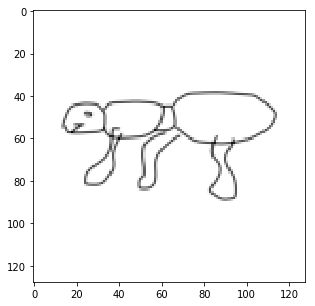

ant


In [3]:
# Plot a random image
sample = np.random.randint(X_train.shape[0])
plt.imshow(X_train[sample].reshape(128, 128))
plt.show()
print (labels[y_train[sample]])

In [4]:
def model(X, y):
    c1 = tf.layers.conv2d(X, 32, [7, 7], padding='SAME') # 128 x 128 x 32
    b1 = tf.layers.batch_normalization(c1)
    h1 = tf.nn.relu(b1)
    p1 = tf.layers.max_pooling2d(h1, [2, 2], [2, 2]) # 64 x 64 x 32
    
    c2 = tf.layers.conv2d(p1, 64, [5, 5], padding='SAME') # 64 x 64 x 64
    b2 = tf.layers.batch_normalization(c2)
    h2 = tf.nn.relu(b2)
    p2 = tf.layers.max_pooling2d(h2, [2, 2], [2, 2]) # 32 x 32 x 64
    
    c3 = tf.layers.conv2d(p2, 128, [3, 3], padding = 'SAME') # 32 x 32 x 128
    b3 = tf.layers.batch_normalization(c3)
    h3 = tf.nn.relu(b3)
    p3 = tf.layers.max_pooling2d(h3, [2, 2], [2, 2]) # 16 x 16 x 128
    
    #p4 = tf.layers.average_pooling2d(p3, [32, 32], [1, 1]) # 1 x 1 x 64
    
    p3_flat = tf.reshape(p3, [-1,32768])
    y_out = tf.layers.dense(p3_flat, num_classes)
    
    return y_out
    
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, res, res, 1])
y = tf.placeholder(tf.int64, [None])

y_out = model(X, y)
print (y_out.shape)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, num_classes), logits=y_out))
optimizer = tf.train.AdamOptimizer()

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

(?, 10)


In [5]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx] }
            
            
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

training
Iteration 0: with minibatch training loss = 52.9 and accuracy of 0.062
Iteration 10: with minibatch training loss = 12.1 and accuracy of 0.062
Epoch 1, Overall loss = 48.8 and accuracy of 0.0953


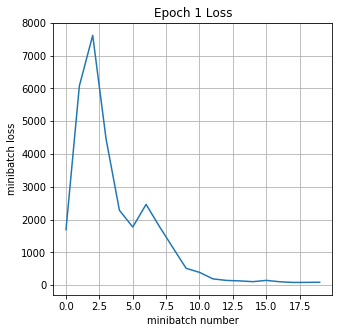

Iteration 20: with minibatch training loss = 2.42 and accuracy of 0.12
Iteration 30: with minibatch training loss = 2.3 and accuracy of 0.094
Epoch 2, Overall loss = 2.3 and accuracy of 0.139


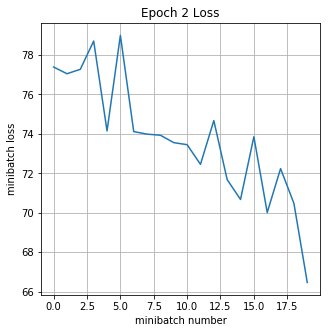

Iteration 40: with minibatch training loss = 1.97 and accuracy of 0.38
Iteration 50: with minibatch training loss = 1.51 and accuracy of 0.47
Epoch 3, Overall loss = 1.57 and accuracy of 0.486


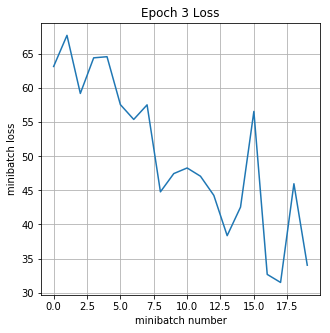

Iteration 60: with minibatch training loss = 1.13 and accuracy of 0.62
Iteration 70: with minibatch training loss = 1.05 and accuracy of 0.62
Epoch 4, Overall loss = 0.963 and accuracy of 0.688


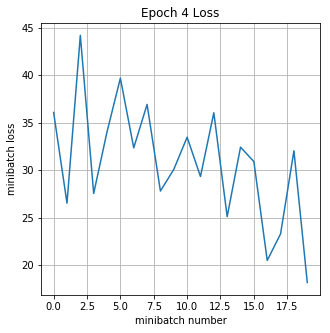

Iteration 80: with minibatch training loss = 0.914 and accuracy of 0.56
Iteration 90: with minibatch training loss = 0.677 and accuracy of 0.78
Epoch 5, Overall loss = 0.553 and accuracy of 0.828


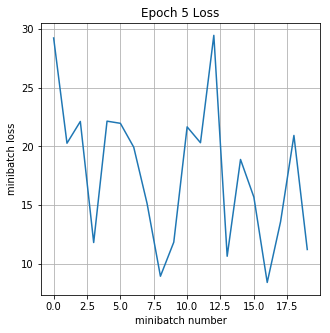

testing
Epoch 1, Overall loss = 0.912 and accuracy of 0.713


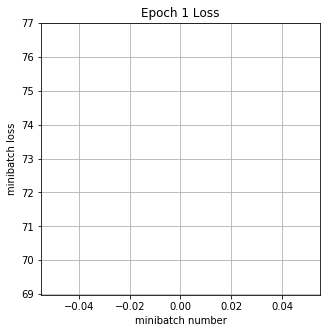

(0.91239297389984131, 0.71250000000000002)

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('training')
run_model(session=sess,
          predict=y_out,
          loss_val=mean_loss,
          Xd=X_train,
          yd=y_train,
          epochs=5,
          batch_size=32,
          print_every=10 ,
          training=train_step,
          plot_losses=True)
print('testing')
run_model(session=sess,
          predict=y_out,
          loss_val=mean_loss,
          Xd=X_val,
          yd=y_val,
          epochs=1,
          batch_size=X_val.shape[0],
          print_every=1,
          training=None,
          plot_losses=True)
#training with 10 num classes though 
#forgot to save weights 

In [8]:
num_classes = 250
res = 128

tic = time.clock()
X_train, y_train, X_val, y_val, X_test, y_test, labels = datautils.get_data(num_classes=num_classes, res=128)
toc = time.clock()
print ("Read {} images in {:5} seconds".format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0], toc - tic))
print ("X_train: ", X_train.shape)
print ("y_train: ", y_train.shape)
print ("X_val: ", X_val.shape)
print ("y_val: ", y_val.shape)
print ("X_test: ", X_test.shape)
print ("y_test: ", y_test.shape)

Read 20000 images in 9.299914999999999 seconds
X_train:  (16000, 128, 128, 1)
y_train:  (16000,)
X_val:  (2000, 128, 128, 1)
y_val:  (2000,)
X_test:  (2000, 128, 128, 1)
y_test:  (2000,)


training
Iteration 0: with minibatch training loss = 0 and accuracy of 0
Iteration 100: with minibatch training loss = 0 and accuracy of 0.031
Iteration 200: with minibatch training loss = 3.64e+08 and accuracy of 0
Iteration 300: with minibatch training loss = 7.9e+09 and accuracy of 0
Iteration 400: with minibatch training loss = 6.31e+09 and accuracy of 0.062
Epoch 1, Overall loss = 1.25e+10 and accuracy of 0.00406


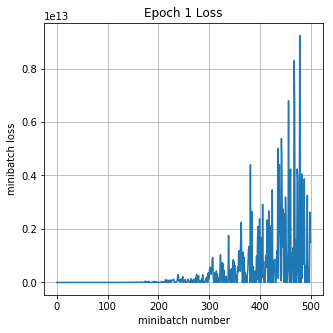

Iteration 500: with minibatch training loss = 0 and accuracy of 0
Iteration 600: with minibatch training loss = 3.86e+11 and accuracy of 0
Iteration 700: with minibatch training loss = 4.1e+11 and accuracy of 0
Iteration 800: with minibatch training loss = 0 and accuracy of 0.062
Iteration 900: with minibatch training loss = 7.31e+12 and accuracy of 0
Epoch 2, Overall loss = 1.25e+12 and accuracy of 0.00438


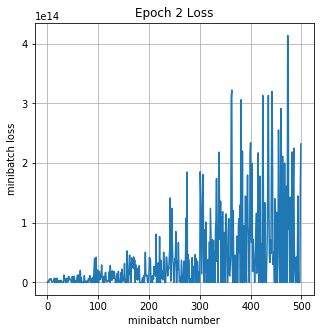

Iteration 1000: with minibatch training loss = 0 and accuracy of 0
Iteration 1100: with minibatch training loss = 1.12e+12 and accuracy of 0
Iteration 1200: with minibatch training loss = 6.51e+12 and accuracy of 0
Iteration 1300: with minibatch training loss = 1.49e+12 and accuracy of 0
Iteration 1400: with minibatch training loss = 2.58e+13 and accuracy of 0.062
Epoch 3, Overall loss = 1.31e+13 and accuracy of 0.00456


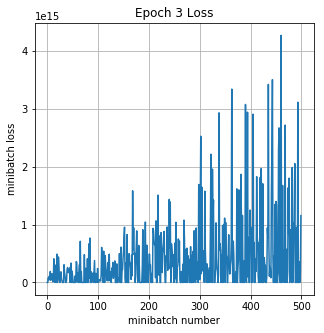

Iteration 1500: with minibatch training loss = 0 and accuracy of 0
Iteration 1600: with minibatch training loss = 3.86e+13 and accuracy of 0
Iteration 1700: with minibatch training loss = 1.45e+12 and accuracy of 0
Iteration 1800: with minibatch training loss = 1.63e+14 and accuracy of 0
Iteration 1900: with minibatch training loss = 2.15e+14 and accuracy of 0
Epoch 4, Overall loss = 7.29e+13 and accuracy of 0.00394


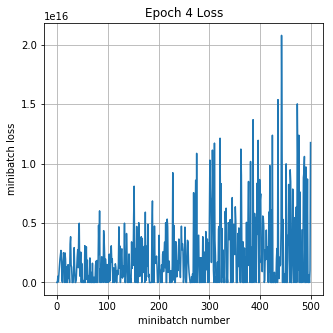

Iteration 2000: with minibatch training loss = 0 and accuracy of 0
Iteration 2100: with minibatch training loss = 1.1e+14 and accuracy of 0
Iteration 2200: with minibatch training loss = 2.05e+14 and accuracy of 0
Iteration 2300: with minibatch training loss = 1.86e+14 and accuracy of 0
Iteration 2400: with minibatch training loss = 1.12e+14 and accuracy of 0.062
Epoch 5, Overall loss = 2.01e+14 and accuracy of 0.00475


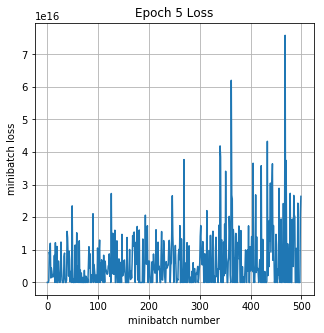

testing


ResourceExhaustedError: OOM when allocating tensor with shape[2000,128,128,32]
	 [[Node: conv2d/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_0/_21, conv2d/kernel/read)]]
	 [[Node: Mean_5/_27 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_221_Mean_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d/convolution', defined at:
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-deba696422f8>", line 28, in <module>
    y_out = model(X, y)
  File "<ipython-input-4-deba696422f8>", line 2, in model
    c1 = tf.layers.conv2d(X, 32, [7, 7], padding='SAME') # 128 x 128 x 32
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/layers/convolutional.py", line 511, in conv2d
    return layer.apply(inputs)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 320, in apply
    return self.__call__(inputs, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 290, in __call__
    outputs = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/layers/convolutional.py", line 156, in call
    data_format=utils.convert_data_format(self.data_format, self.rank + 2))
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 661, in convolution
    op=op)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 331, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 653, in op
    name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 403, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[2000,128,128,32]
	 [[Node: conv2d/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_0/_21, conv2d/kernel/read)]]
	 [[Node: Mean_5/_27 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_221_Mean_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('training')
run_model(session=sess,
          predict=y_out,
          loss_val=mean_loss,
          Xd=X_train,
          yd=y_train,
          epochs=5,
          batch_size=32,
          print_every=100,
          training=train_step,
          plot_losses=True)



testing
Epoch 1, Overall loss = 3.67e+14 and accuracy of 0.004


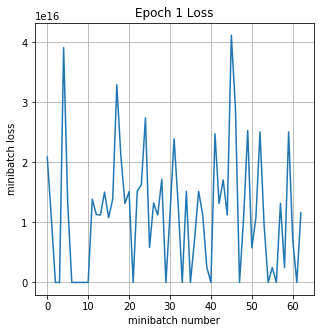

(367177510049284.12, 0.0040000000000000001)

In [12]:
print('testing')
run_model(session=sess,
          predict=y_out,
          loss_val=mean_loss,
          Xd=X_val,
          yd=y_val,
          epochs=1,
          batch_size=32,
          print_every=1,
          training=None,
          plot_losses=True)

training
Iteration 0: with minibatch training loss = 0 and accuracy of 0
Iteration 100: with minibatch training loss = 8.84e+06 and accuracy of 0
Iteration 200: with minibatch training loss = 2.1e+07 and accuracy of 0
Iteration 300: with minibatch training loss = 5.09e+09 and accuracy of 0
Iteration 400: with minibatch training loss = 0 and accuracy of 0.031
Epoch 1, Overall loss = 6.88e+09 and accuracy of 0.00431


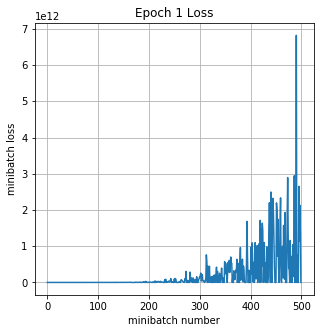

Iteration 500: with minibatch training loss = 0 and accuracy of 0
Iteration 600: with minibatch training loss = 3.4e+11 and accuracy of 0.062
Iteration 700: with minibatch training loss = 3.35e+11 and accuracy of 0
Iteration 800: with minibatch training loss = 6.81e+11 and accuracy of 0
Iteration 900: with minibatch training loss = 0 and accuracy of 0.031
Epoch 2, Overall loss = 6.84e+11 and accuracy of 0.004


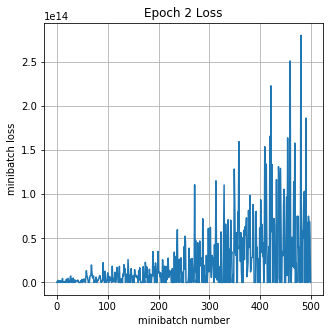

Iteration 1000: with minibatch training loss = 0 and accuracy of 0
Iteration 1100: with minibatch training loss = 8.5e+12 and accuracy of 0
Iteration 1200: with minibatch training loss = 2.46e+12 and accuracy of 0
Iteration 1300: with minibatch training loss = 1.83e+12 and accuracy of 0
Iteration 1400: with minibatch training loss = 3.37e+12 and accuracy of 0
Epoch 3, Overall loss = 7.84e+12 and accuracy of 0.00356


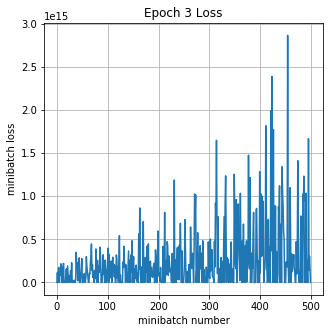

Iteration 1500: with minibatch training loss = 0 and accuracy of 0
Iteration 1600: with minibatch training loss = 2.87e+13 and accuracy of 0.031
Iteration 1700: with minibatch training loss = 1.01e+13 and accuracy of 0
Iteration 1800: with minibatch training loss = 1.23e+13 and accuracy of 0
Iteration 1900: with minibatch training loss = 4.76e+12 and accuracy of 0
Epoch 4, Overall loss = 3.94e+13 and accuracy of 0.00481


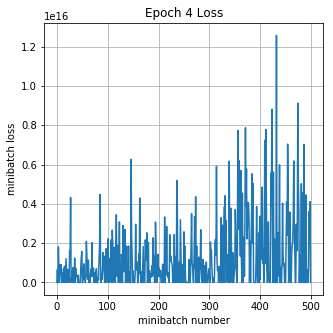

Iteration 2000: with minibatch training loss = 0 and accuracy of 0
Iteration 2100: with minibatch training loss = 2.82e+14 and accuracy of 0
Iteration 2200: with minibatch training loss = 3.18e+13 and accuracy of 0
Iteration 2300: with minibatch training loss = 6.9e+13 and accuracy of 0
Iteration 2400: with minibatch training loss = 4.98e+13 and accuracy of 0
Epoch 5, Overall loss = 1.29e+14 and accuracy of 0.00387


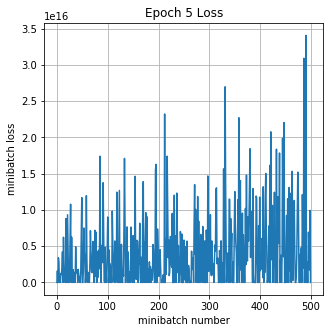

Iteration 2500: with minibatch training loss = 0 and accuracy of 0
Iteration 2600: with minibatch training loss = 1.23e+14 and accuracy of 0
Iteration 2700: with minibatch training loss = 7.98e+13 and accuracy of 0
Iteration 2800: with minibatch training loss = 1e+14 and accuracy of 0
Iteration 2900: with minibatch training loss = 1.51e+14 and accuracy of 0
Epoch 6, Overall loss = 3.39e+14 and accuracy of 0.00419


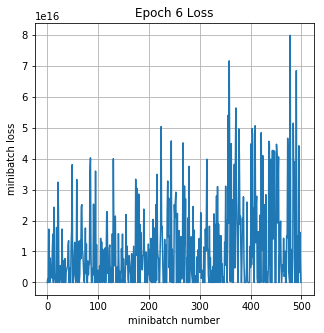

Iteration 3000: with minibatch training loss = 0 and accuracy of 0
Iteration 3100: with minibatch training loss = 1.2e+15 and accuracy of 0
Iteration 3200: with minibatch training loss = 1.12e+14 and accuracy of 0
Iteration 3300: with minibatch training loss = 5.54e+13 and accuracy of 0
Iteration 3400: with minibatch training loss = 3.39e+14 and accuracy of 0
Epoch 7, Overall loss = 6.8e+14 and accuracy of 0.00344


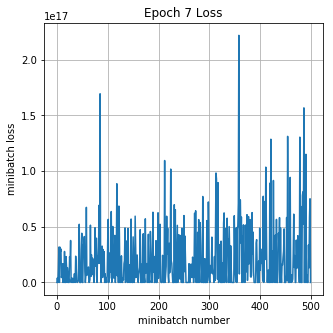

Iteration 3500: with minibatch training loss = 0 and accuracy of 0
Iteration 3600: with minibatch training loss = 2.36e+15 and accuracy of 0
Iteration 3700: with minibatch training loss = 0 and accuracy of 0.031
Iteration 3800: with minibatch training loss = 2.55e+15 and accuracy of 0
Iteration 3900: with minibatch training loss = 6.27e+14 and accuracy of 0
Epoch 8, Overall loss = 1.31e+15 and accuracy of 0.00287


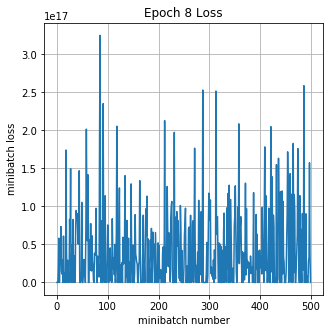

Iteration 4000: with minibatch training loss = 0 and accuracy of 0
Iteration 4100: with minibatch training loss = 4.05e+15 and accuracy of 0
Iteration 4200: with minibatch training loss = 5.19e+14 and accuracy of 0
Iteration 4300: with minibatch training loss = 1.37e+15 and accuracy of 0
Iteration 4400: with minibatch training loss = 1.69e+15 and accuracy of 0
Epoch 9, Overall loss = 1.9e+15 and accuracy of 0.00363


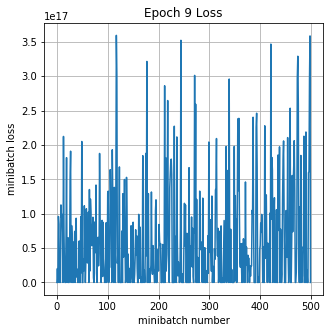

Iteration 4500: with minibatch training loss = 0 and accuracy of 0
Iteration 4600: with minibatch training loss = 7.83e+15 and accuracy of 0.031
Iteration 4700: with minibatch training loss = 1.77e+15 and accuracy of 0
Iteration 4800: with minibatch training loss = 8.42e+14 and accuracy of 0
Iteration 4900: with minibatch training loss = 3.28e+15 and accuracy of 0
Epoch 10, Overall loss = 3.29e+15 and accuracy of 0.00425


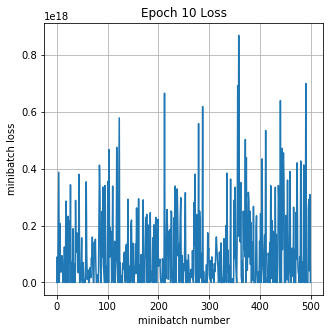

Iteration 5000: with minibatch training loss = 0 and accuracy of 0
Iteration 5100: with minibatch training loss = 1.42e+16 and accuracy of 0
Iteration 5200: with minibatch training loss = 8.31e+14 and accuracy of 0
Iteration 5300: with minibatch training loss = 2.88e+15 and accuracy of 0
Iteration 5400: with minibatch training loss = 1.34e+16 and accuracy of 0
Epoch 11, Overall loss = 4.86e+15 and accuracy of 0.00319


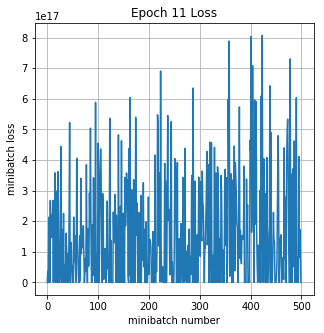

Iteration 5500: with minibatch training loss = 0 and accuracy of 0
Iteration 5600: with minibatch training loss = 2.73e+16 and accuracy of 0
Iteration 5700: with minibatch training loss = 9.93e+15 and accuracy of 0
Iteration 5800: with minibatch training loss = 1.36e+16 and accuracy of 0
Iteration 5900: with minibatch training loss = 2.63e+15 and accuracy of 0
Epoch 12, Overall loss = 7.58e+15 and accuracy of 0.00425


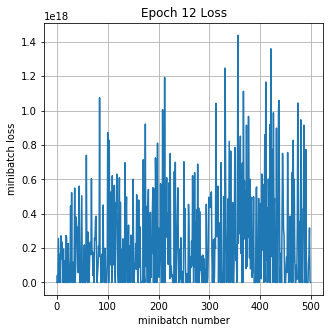

Iteration 6000: with minibatch training loss = 0 and accuracy of 0
Iteration 6100: with minibatch training loss = 2.48e+16 and accuracy of 0.062
Iteration 6200: with minibatch training loss = 5.37e+15 and accuracy of 0
Iteration 6300: with minibatch training loss = 2.83e+16 and accuracy of 0
Iteration 6400: with minibatch training loss = 1.82e+16 and accuracy of 0
Epoch 13, Overall loss = 1.01e+16 and accuracy of 0.00456


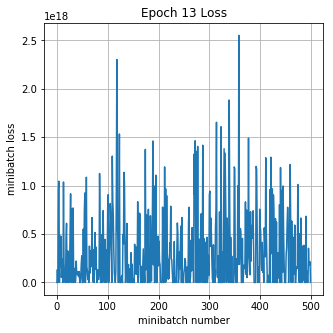

Iteration 6500: with minibatch training loss = 0 and accuracy of 0
Iteration 6600: with minibatch training loss = 1.99e+16 and accuracy of 0
Iteration 6700: with minibatch training loss = 4.09e+14 and accuracy of 0
Iteration 6800: with minibatch training loss = 4.41e+15 and accuracy of 0
Iteration 6900: with minibatch training loss = 8.4e+15 and accuracy of 0
Epoch 14, Overall loss = 1.33e+16 and accuracy of 0.00519


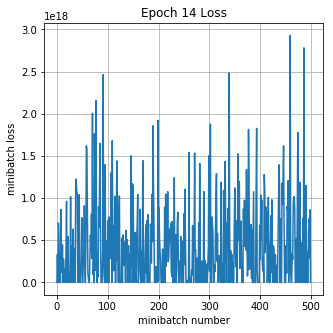

Iteration 7000: with minibatch training loss = 0 and accuracy of 0
Iteration 7100: with minibatch training loss = 1.1e+17 and accuracy of 0
Iteration 7200: with minibatch training loss = 0 and accuracy of 0.031
Iteration 7300: with minibatch training loss = 2.55e+16 and accuracy of 0
Iteration 7400: with minibatch training loss = 6.85e+15 and accuracy of 0
Epoch 15, Overall loss = 1.86e+16 and accuracy of 0.00394


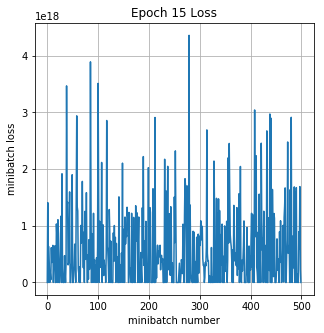

Iteration 7500: with minibatch training loss = 0 and accuracy of 0
Iteration 7600: with minibatch training loss = 4.46e+16 and accuracy of 0
Iteration 7700: with minibatch training loss = 3.45e+16 and accuracy of 0
Iteration 7800: with minibatch training loss = 5.59e+16 and accuracy of 0
Iteration 7900: with minibatch training loss = 2.48e+16 and accuracy of 0
Epoch 16, Overall loss = 2.3e+16 and accuracy of 0.00337


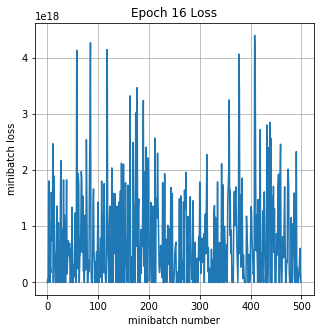

Iteration 8000: with minibatch training loss = 0 and accuracy of 0
Iteration 8100: with minibatch training loss = 2.56e+16 and accuracy of 0.031
Iteration 8200: with minibatch training loss = 1.57e+16 and accuracy of 0
Iteration 8300: with minibatch training loss = 0 and accuracy of 0.031
Iteration 8400: with minibatch training loss = 3.72e+16 and accuracy of 0
Epoch 17, Overall loss = 2.87e+16 and accuracy of 0.00413


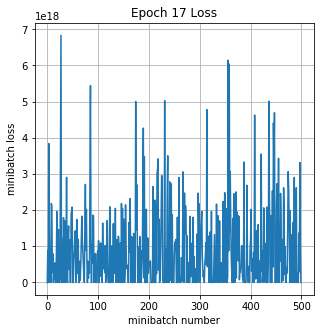

Iteration 8500: with minibatch training loss = 0 and accuracy of 0
Iteration 8600: with minibatch training loss = 1.67e+17 and accuracy of 0.031
Iteration 8700: with minibatch training loss = 3.45e+15 and accuracy of 0
Iteration 8800: with minibatch training loss = 4.68e+16 and accuracy of 0
Iteration 8900: with minibatch training loss = 4.27e+16 and accuracy of 0
Epoch 18, Overall loss = 3.98e+16 and accuracy of 0.00475


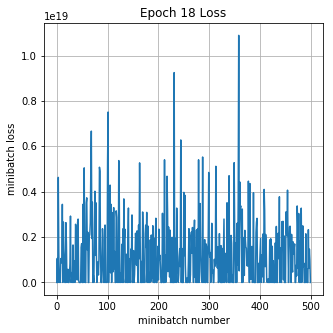

Iteration 9000: with minibatch training loss = 0 and accuracy of 0
Iteration 9100: with minibatch training loss = 1.99e+17 and accuracy of 0
Iteration 9200: with minibatch training loss = 0 and accuracy of 0.031
Iteration 9300: with minibatch training loss = 6.58e+16 and accuracy of 0
Iteration 9400: with minibatch training loss = 7.79e+16 and accuracy of 0
Epoch 19, Overall loss = 4.98e+16 and accuracy of 0.00356


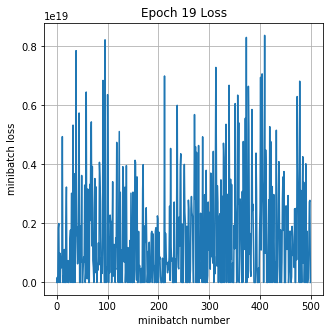

Iteration 9500: with minibatch training loss = 0 and accuracy of 0
Iteration 9600: with minibatch training loss = 1.78e+16 and accuracy of 0
Iteration 9700: with minibatch training loss = 1.23e+17 and accuracy of 0
Iteration 9800: with minibatch training loss = 8.08e+06 and accuracy of 0
Iteration 9900: with minibatch training loss = 5.76e+06 and accuracy of 0
Epoch 20, Overall loss = 2.71e+16 and accuracy of 0.00438


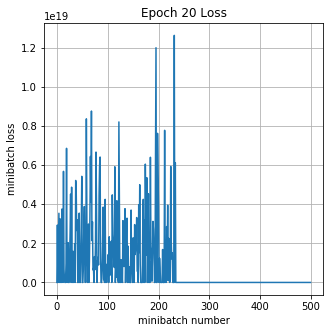

Iteration 10000: with minibatch training loss = 0 and accuracy of 0
Iteration 10100: with minibatch training loss = 2.43e+07 and accuracy of 0
Iteration 10200: with minibatch training loss = 4.22e+06 and accuracy of 0
Iteration 10300: with minibatch training loss = 7.55e+06 and accuracy of 0
Iteration 10400: with minibatch training loss = 5.27e+06 and accuracy of 0
Epoch 21, Overall loss = 7.98e+06 and accuracy of 0.004


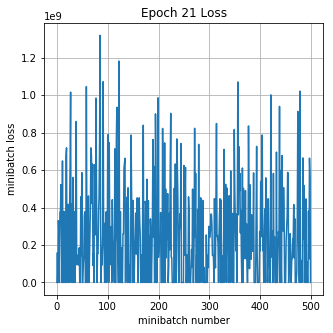

Iteration 10500: with minibatch training loss = 0 and accuracy of 0
Iteration 10600: with minibatch training loss = 2.09e+07 and accuracy of 0
Iteration 10700: with minibatch training loss = 2.82e+06 and accuracy of 0
Iteration 10800: with minibatch training loss = 5.94e+06 and accuracy of 0
Iteration 10900: with minibatch training loss = 3.4e+06 and accuracy of 0
Epoch 22, Overall loss = 6.34e+06 and accuracy of 0.004


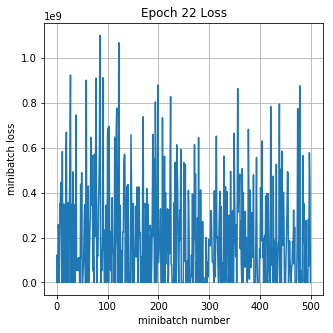

Iteration 11000: with minibatch training loss = 0 and accuracy of 0
Iteration 11100: with minibatch training loss = 1.55e+07 and accuracy of 0
Iteration 11200: with minibatch training loss = 1.03e+06 and accuracy of 0
Iteration 11300: with minibatch training loss = 4.76e+06 and accuracy of 0
Iteration 11400: with minibatch training loss = 2.27e+06 and accuracy of 0
Epoch 23, Overall loss = 4.72e+06 and accuracy of 0.00431


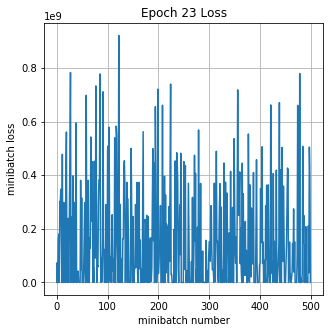

Iteration 11500: with minibatch training loss = 0 and accuracy of 0
Iteration 11600: with minibatch training loss = 1.24e+07 and accuracy of 0
Iteration 11700: with minibatch training loss = 9.83e+04 and accuracy of 0
Iteration 11800: with minibatch training loss = 3.86e+06 and accuracy of 0
Iteration 11900: with minibatch training loss = 1.21e+06 and accuracy of 0
Epoch 24, Overall loss = 3.81e+06 and accuracy of 0.00431


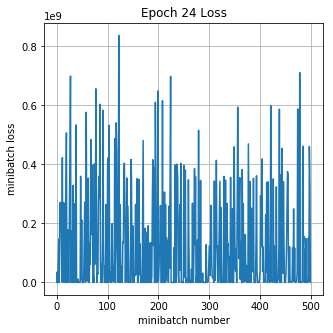

Iteration 12000: with minibatch training loss = 0 and accuracy of 0
Iteration 12100: with minibatch training loss = 1.04e+07 and accuracy of 0
Iteration 12200: with minibatch training loss = 0 and accuracy of 0.031
Iteration 12300: with minibatch training loss = 3.07e+06 and accuracy of 0
Iteration 12400: with minibatch training loss = 5.45e+05 and accuracy of 0
Epoch 25, Overall loss = 3.27e+06 and accuracy of 0.00431


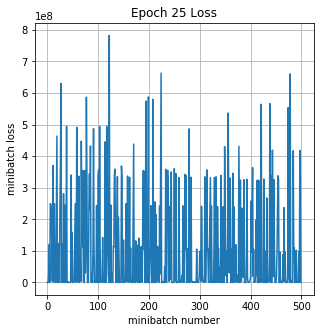

Iteration 12500: with minibatch training loss = 0 and accuracy of 0
Iteration 12600: with minibatch training loss = 8.2e+06 and accuracy of 0
Iteration 12700: with minibatch training loss = 7.68e+04 and accuracy of 0
Iteration 12800: with minibatch training loss = 2.14e+06 and accuracy of 0
Iteration 12900: with minibatch training loss = 1.84e+04 and accuracy of 0
Epoch 26, Overall loss = 2.8e+06 and accuracy of 0.00413


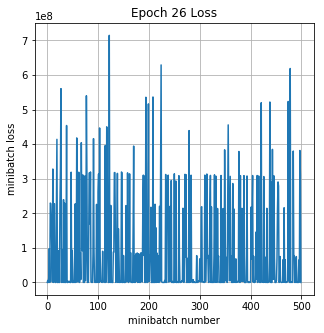

Iteration 13000: with minibatch training loss = 0 and accuracy of 0
Iteration 13100: with minibatch training loss = 6.6e+06 and accuracy of 0
Iteration 13200: with minibatch training loss = 1.09e+05 and accuracy of 0
Iteration 13300: with minibatch training loss = 1.73e+06 and accuracy of 0
Iteration 13400: with minibatch training loss = 9.32e+04 and accuracy of 0
Epoch 27, Overall loss = 2.58e+06 and accuracy of 0.005


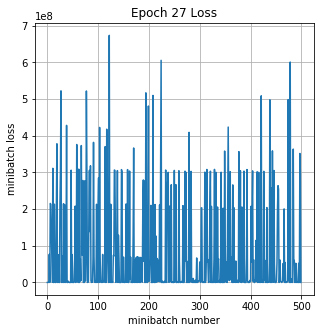

Iteration 13500: with minibatch training loss = 0 and accuracy of 0
Iteration 13600: with minibatch training loss = 4.89e+06 and accuracy of 0
Iteration 13700: with minibatch training loss = 7.17e+03 and accuracy of 0
Iteration 13800: with minibatch training loss = 1.28e+06 and accuracy of 0
Iteration 13900: with minibatch training loss = 0 and accuracy of 0.031
Epoch 28, Overall loss = 2.36e+06 and accuracy of 0.00444


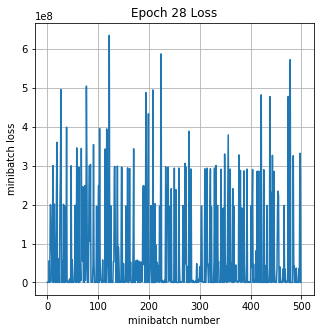

Iteration 14000: with minibatch training loss = 0 and accuracy of 0
Iteration 14100: with minibatch training loss = 3.18e+06 and accuracy of 0
Iteration 14200: with minibatch training loss = 3.07e+04 and accuracy of 0
Iteration 14300: with minibatch training loss = 4.81e+05 and accuracy of 0
Iteration 14400: with minibatch training loss = 8.5e+04 and accuracy of 0
Epoch 29, Overall loss = 2.04e+06 and accuracy of 0.00425


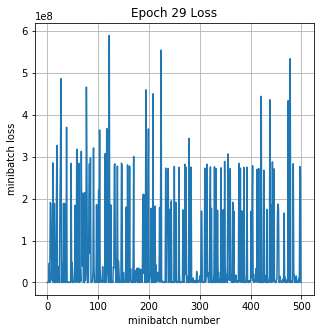

Iteration 14500: with minibatch training loss = 0 and accuracy of 0
Iteration 14600: with minibatch training loss = 4.25e+05 and accuracy of 0
Iteration 14700: with minibatch training loss = 1.74e+04 and accuracy of 0
Iteration 14800: with minibatch training loss = 8.81e+04 and accuracy of 0
Iteration 14900: with minibatch training loss = 0 and accuracy of 0.031
Epoch 30, Overall loss = 1.7e+06 and accuracy of 0.00356


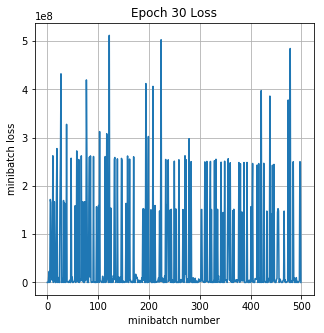

Iteration 15000: with minibatch training loss = 0 and accuracy of 0
Iteration 15100: with minibatch training loss = 5.73e+04 and accuracy of 0.031
Iteration 15200: with minibatch training loss = 9.32e+04 and accuracy of 0
Iteration 15300: with minibatch training loss = 3.48e+04 and accuracy of 0
Iteration 15400: with minibatch training loss = 1.42e+05 and accuracy of 0
Epoch 31, Overall loss = 1.47e+06 and accuracy of 0.00356


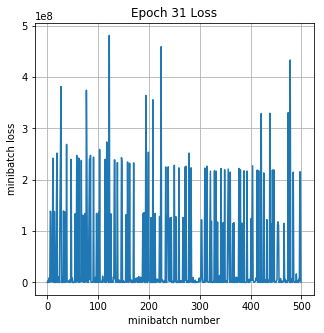

Iteration 15500: with minibatch training loss = 0 and accuracy of 0
Iteration 15600: with minibatch training loss = 1.66e+05 and accuracy of 0
Iteration 15700: with minibatch training loss = 5.63e+04 and accuracy of 0
Iteration 15800: with minibatch training loss = 9.32e+04 and accuracy of 0
Iteration 15900: with minibatch training loss = 0 and accuracy of 0.031
Epoch 32, Overall loss = 1.3e+06 and accuracy of 0.00337


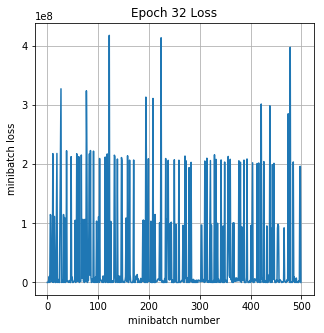

Iteration 16000: with minibatch training loss = 0 and accuracy of 0
Iteration 16100: with minibatch training loss = 3.89e+04 and accuracy of 0.062
Iteration 16200: with minibatch training loss = 1.27e+05 and accuracy of 0
Iteration 16300: with minibatch training loss = 0 and accuracy of 0.031
Iteration 16400: with minibatch training loss = 1.25e+05 and accuracy of 0
Epoch 33, Overall loss = 1.13e+06 and accuracy of 0.00481


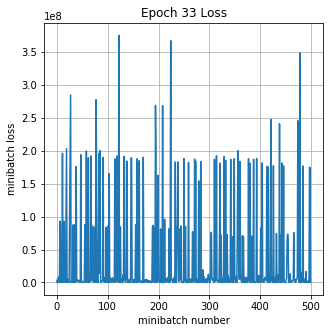

Iteration 16500: with minibatch training loss = 0 and accuracy of 0
Iteration 16600: with minibatch training loss = 4.36e+05 and accuracy of 0
Iteration 16700: with minibatch training loss = 6.35e+04 and accuracy of 0
Iteration 16800: with minibatch training loss = 9.83e+04 and accuracy of 0
Iteration 16900: with minibatch training loss = 1.47e+05 and accuracy of 0
Epoch 34, Overall loss = 9.43e+05 and accuracy of 0.00381


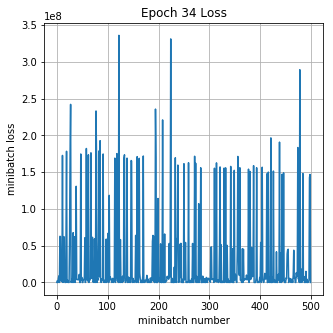

Iteration 17000: with minibatch training loss = 0 and accuracy of 0
Iteration 17100: with minibatch training loss = 6.55e+04 and accuracy of 0.062
Iteration 17200: with minibatch training loss = 8.4e+04 and accuracy of 0
Iteration 17300: with minibatch training loss = 1.58e+05 and accuracy of 0
Iteration 17400: with minibatch training loss = 1.45e+05 and accuracy of 0
Epoch 35, Overall loss = 6.91e+05 and accuracy of 0.00394


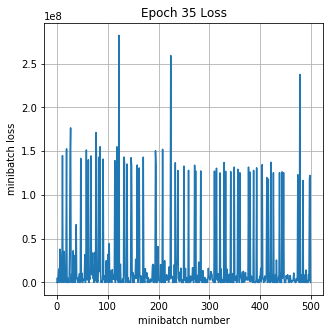

Iteration 17500: with minibatch training loss = 0 and accuracy of 0
Iteration 17600: with minibatch training loss = 3.81e+05 and accuracy of 0
Iteration 17700: with minibatch training loss = 1.31e+05 and accuracy of 0
Iteration 17800: with minibatch training loss = 3.07e+04 and accuracy of 0
Iteration 17900: with minibatch training loss = 9.83e+04 and accuracy of 0
Epoch 36, Overall loss = 5.26e+05 and accuracy of 0.00313


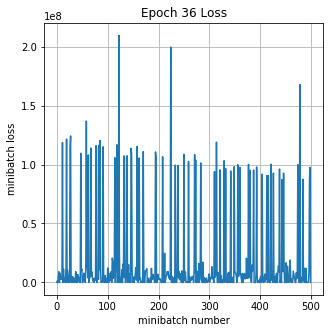

Iteration 18000: with minibatch training loss = 0 and accuracy of 0
Iteration 18100: with minibatch training loss = 1.02e+05 and accuracy of 0.031
Iteration 18200: with minibatch training loss = 1.54e+05 and accuracy of 0
Iteration 18300: with minibatch training loss = 1.31e+05 and accuracy of 0
Iteration 18400: with minibatch training loss = 2.62e+05 and accuracy of 0
Epoch 37, Overall loss = 3.89e+05 and accuracy of 0.0035


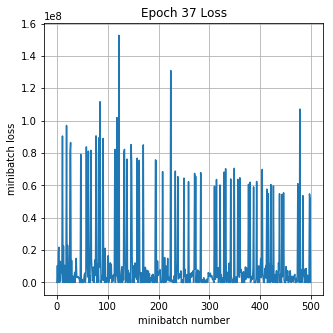

Iteration 18500: with minibatch training loss = 0 and accuracy of 0
Iteration 18600: with minibatch training loss = 3.73e+05 and accuracy of 0
Iteration 18700: with minibatch training loss = 1.7e+05 and accuracy of 0
Iteration 18800: with minibatch training loss = 1.02e+04 and accuracy of 0
Iteration 18900: with minibatch training loss = 2.83e+05 and accuracy of 0
Epoch 38, Overall loss = 2.22e+05 and accuracy of 0.00313


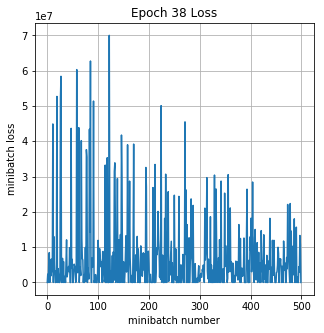

Iteration 19000: with minibatch training loss = 0 and accuracy of 0
Iteration 19100: with minibatch training loss = 1.88e+05 and accuracy of 0
Iteration 19200: with minibatch training loss = 2.23e+05 and accuracy of 0
Iteration 19300: with minibatch training loss = 1.15e+05 and accuracy of 0
Iteration 19400: with minibatch training loss = 0.0217 and accuracy of 0
Epoch 39, Overall loss = 1.37e+05 and accuracy of 0.003


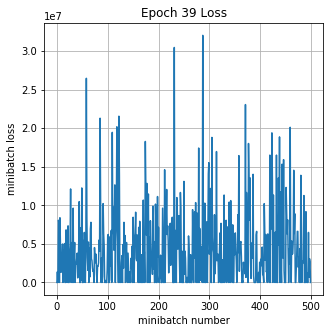

Iteration 19500: with minibatch training loss = 0 and accuracy of 0
Iteration 19600: with minibatch training loss = 1.27e+05 and accuracy of 0
Iteration 19700: with minibatch training loss = 3.89e+04 and accuracy of 0
Iteration 19800: with minibatch training loss = 0 and accuracy of 0.031
Iteration 19900: with minibatch training loss = 1.35e+05 and accuracy of 0
Epoch 40, Overall loss = 1.34e+05 and accuracy of 0.00387


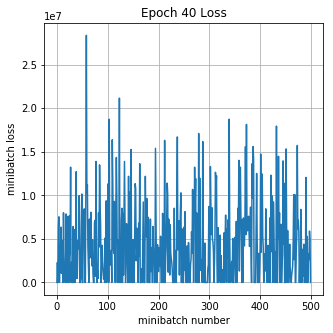

Iteration 20000: with minibatch training loss = 0 and accuracy of 0
Iteration 20100: with minibatch training loss = 1.43e+05 and accuracy of 0.031
Iteration 20200: with minibatch training loss = 1.19e+05 and accuracy of 0
Iteration 20300: with minibatch training loss = 1.11e+05 and accuracy of 0
Iteration 20400: with minibatch training loss = 1.9e+05 and accuracy of 0
Epoch 41, Overall loss = 1.34e+05 and accuracy of 0.00481


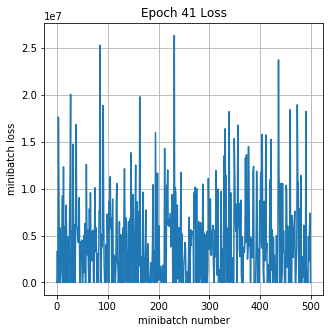

Iteration 20500: with minibatch training loss = 0 and accuracy of 0
Iteration 20600: with minibatch training loss = 2.56e+05 and accuracy of 0
Iteration 20700: with minibatch training loss = 1.76e+05 and accuracy of 0
Iteration 20800: with minibatch training loss = 9.83e+04 and accuracy of 0
Iteration 20900: with minibatch training loss = 1.25e+05 and accuracy of 0
Epoch 42, Overall loss = 1.38e+05 and accuracy of 0.00356


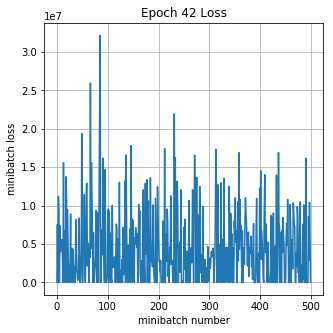

Iteration 21000: with minibatch training loss = 0 and accuracy of 0
Iteration 21100: with minibatch training loss = 6.96e+04 and accuracy of 0
Iteration 21200: with minibatch training loss = 1.37e+05 and accuracy of 0
Iteration 21300: with minibatch training loss = 4.1e+04 and accuracy of 0
Iteration 21400: with minibatch training loss = 6.96e+04 and accuracy of 0
Epoch 43, Overall loss = 1.28e+05 and accuracy of 0.00413


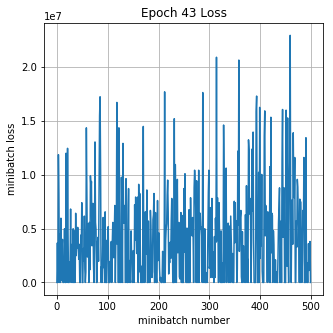

Iteration 21500: with minibatch training loss = 0 and accuracy of 0
Iteration 21600: with minibatch training loss = 1.09e+05 and accuracy of 0.062
Iteration 21700: with minibatch training loss = 6.76e+04 and accuracy of 0
Iteration 21800: with minibatch training loss = 3.07e+04 and accuracy of 0
Iteration 21900: with minibatch training loss = 2.5e+05 and accuracy of 0
Epoch 44, Overall loss = 1.58e+05 and accuracy of 0.00431


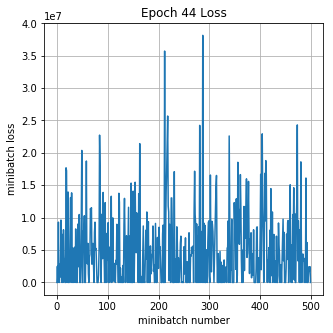

Iteration 22000: with minibatch training loss = 0 and accuracy of 0
Iteration 22100: with minibatch training loss = 3.38e+05 and accuracy of 0
Iteration 22200: with minibatch training loss = 1.43e+05 and accuracy of 0
Iteration 22300: with minibatch training loss = 1.21e+05 and accuracy of 0
Iteration 22400: with minibatch training loss = 0 and accuracy of 0.031
Epoch 45, Overall loss = 1.65e+05 and accuracy of 0.00394


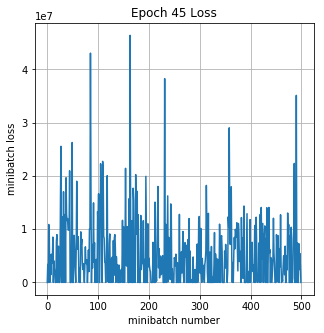

Iteration 22500: with minibatch training loss = 0 and accuracy of 0
Iteration 22600: with minibatch training loss = 3.85e+05 and accuracy of 0
Iteration 22700: with minibatch training loss = 1.82e+05 and accuracy of 0
Iteration 22800: with minibatch training loss = 2.05e+05 and accuracy of 0
Iteration 22900: with minibatch training loss = 6.96e+04 and accuracy of 0
Epoch 46, Overall loss = 1.95e+05 and accuracy of 0.00387


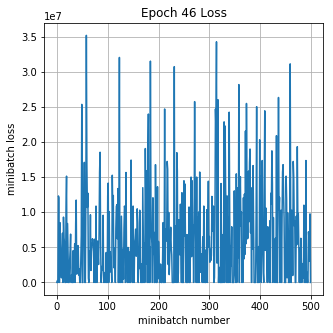

Iteration 23000: with minibatch training loss = 0 and accuracy of 0
Iteration 23100: with minibatch training loss = 1.21e+05 and accuracy of 0
Iteration 23200: with minibatch training loss = 9.83e+04 and accuracy of 0
Iteration 23300: with minibatch training loss = 2.19e+05 and accuracy of 0
Iteration 23400: with minibatch training loss = 2.31e+05 and accuracy of 0
Epoch 47, Overall loss = 1.97e+05 and accuracy of 0.00475


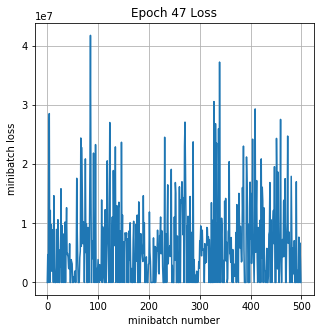

Iteration 23500: with minibatch training loss = 0 and accuracy of 0
Iteration 23600: with minibatch training loss = 1.84e+05 and accuracy of 0
Iteration 23700: with minibatch training loss = 3.71e+05 and accuracy of 0
Iteration 23800: with minibatch training loss = 0 and accuracy of 0.031
Iteration 23900: with minibatch training loss = 4.53e+05 and accuracy of 0
Epoch 48, Overall loss = 2.37e+05 and accuracy of 0.004


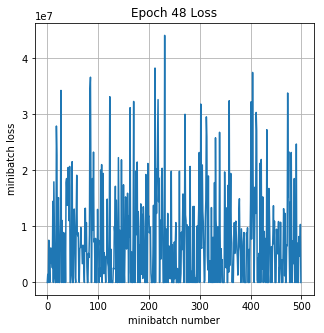

Iteration 24000: with minibatch training loss = 0 and accuracy of 0
Iteration 24100: with minibatch training loss = 7.31e+05 and accuracy of 0
Iteration 24200: with minibatch training loss = 3.22e+05 and accuracy of 0
Iteration 24300: with minibatch training loss = 3.93e+05 and accuracy of 0
Iteration 24400: with minibatch training loss = 0 and accuracy of 0.031
Epoch 49, Overall loss = 2.85e+05 and accuracy of 0.0045


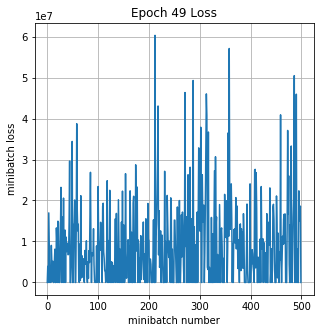

Iteration 24500: with minibatch training loss = 0 and accuracy of 0
Iteration 24600: with minibatch training loss = 3.26e+05 and accuracy of 0
Iteration 24700: with minibatch training loss = 3.13e+05 and accuracy of 0
Iteration 24800: with minibatch training loss = 4.24e+05 and accuracy of 0
Iteration 24900: with minibatch training loss = 3.07e+05 and accuracy of 0
Epoch 50, Overall loss = 3.35e+05 and accuracy of 0.00375


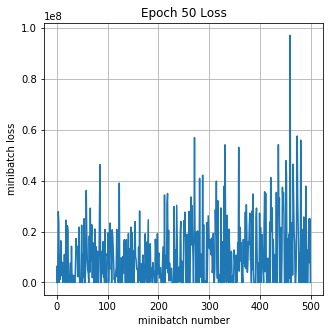

(335372.28846875002, 0.0037499999999999999)

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('training')
run_model(session=sess,
          predict=y_out,
          loss_val=mean_loss,
          Xd=X_train,
          yd=y_train,
          epochs=50,
          batch_size=32,
          print_every=100,
          training=train_step,
          plot_losses=True)


testing
Epoch 1, Overall loss = 4.1e+05 and accuracy of 0.004


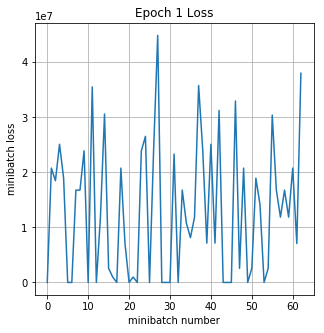

(410058.75199999998, 0.0040000000000000001)

In [15]:
print('testing')
run_model(session=sess,
          predict=y_out,
          loss_val=mean_loss,
          Xd=X_val,
          yd=y_val,
          epochs=1,
          batch_size=32,
          print_every=1,
          training=None,
          plot_losses=True)
